In [ ]:
import pickle
import numpy as np
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
import warnings
import os
warnings.filterwarnings('ignore')

: 

In [8]:

class POIRecommendationModel:
    def __init__(self):
        self.scaler = StandardScaler()
        self.dbscan = None
        self.data = None
        self.features = None
        self.clusters = None
        self.difficulty_encoder = LabelEncoder()
        
    def load_and_preprocess_data(self, csv_file_path):
        """Load and preprocess the POI dataset"""
        print("Loading and preprocessing data...")
        
        
        if not os.path.exists(csv_file_path):
            raise FileNotFoundError(f"CSV file '{csv_file_path}' not found. Please ensure the file exists in the current directory.")
        
        # Load the dataset 
        try:
            
            self.data = pd.read_csv(csv_file_path)
            print(f"Dataset loaded with {len(self.data)} POIs")
        except pd.errors.ParserError as e:
            print(f"Parser error encountered: {e}")
            try:
                
                self.data = pd.read_csv(csv_file_path, 
                                      on_bad_lines='skip')  
                print(f"Dataset loaded with {len(self.data)} POIs after skipping bad lines")
            except (TypeError, ValueError):
                try:
                    
                    self.data = pd.read_csv(csv_file_path, 
                                          error_bad_lines=False,
                                          warn_bad_lines=True)
                    print(f"Dataset loaded with {len(self.data)} POIs using older pandas syntax")
                except (TypeError, ValueError):
                    
                    self.data = pd.read_csv(csv_file_path, 
                                          engine='python',
                                          sep=',',
                                          quotechar='"',
                                          skipinitialspace=True)
                    print(f"Dataset loaded with {len(self.data)} POIs using Python engine")
        except Exception as e:
            raise Exception(f"Error loading CSV file: {e}")
        
        # Clean and preprocess the data
        self.data = self._clean_data()
        
        # Extract features for clustering
        self.features = self._extract_features()
        
        print("Data preprocessing completed!")
        return self.data
    
    def _clean_data(self):
        """Clean and standardize the dataset"""
        df = self.data.copy()
        
        # Check if required columns exist
        required_columns = ['difficulty', 'elevation', 'duration', 'cost', 'poi_name']
        missing_columns = [col for col in required_columns if col not in df.columns]
        
        if missing_columns:
            print(f"Warning: Missing columns {missing_columns}. Using default values.")
            
            if 'difficulty' not in df.columns:
                df['difficulty'] = 'moderate'
            if 'elevation' not in df.columns:
                df['elevation'] = '3000 meters'
            if 'duration' not in df.columns:
                df['duration'] = '5-7 days'
            if 'cost' not in df.columns:
                df['cost'] = '10000-15000 NPR'
            if 'poi_name' not in df.columns:
                df['poi_name'] = [f'POI_{i}' for i in range(len(df))]
        
        
        if 'difficulty' in df.columns:
            df = df[~df['difficulty'].str.contains('Taplejung', case=False, na=False)]
        
        # Clean elevation data (remove 'meters' and convert to numeric)
        
        df['elevation_numeric'] = df['elevation'].astype(str).str.replace(' meters', '').str.extract(r'(\d+)').astype(float)
        df['elevation_numeric'] = df['elevation_numeric'].fillna(3000)  # Default elevation
        
        # Clean duration data (extract maximum days)
        df['duration_days'] = df['duration'].apply(self._extract_max_days)
        
        # Clean cost data (extract maximum cost)
        df['cost_numeric'] = df['cost'].apply(self._extract_max_cost)
        
        # Standardize difficulty levels
        df['difficulty_clean'] = df['difficulty'].apply(self._standardize_difficulty)
        
        return df
    
    def _extract_max_days(self, duration_str):
        """Extract maximum number of days from duration string"""
        try:
            
            duration_str = str(duration_str).lower()
            
            if 'week' in duration_str:
                
                import re
                numbers = re.findall(r'\d+', duration_str)
                if numbers:
                    return max([int(n) for n in numbers]) * 7
                else:
                    return 14  
            else:
                
                import re
                numbers = re.findall(r'\d+', duration_str)
                if numbers:
                    return max([int(n) for n in numbers])
                else:
                    return 7  
        except:
            return 7  
    
    def _extract_max_cost(self, cost_str):
        """Extract maximum cost from cost string"""
        try:
            
            cost_str = str(cost_str).lower()
            
            
            cost_str = cost_str.replace('npr', '').replace('around', '').replace('to', ' ')
            
            
            import re
            numbers = re.findall(r'\d+', cost_str)
            
            if numbers:
                
                return max([int(n) for n in numbers])
            else:
                return 10000  
        except:
            return 10000  
    
    def _standardize_difficulty(self, difficulty_str):
        """Standardize difficulty levels"""
        difficulty_str = str(difficulty_str).lower()
        
        if any(word in difficulty_str for word in ['beginner', 'easy', 'friendly']):
            return 'beginner'
        elif any(word in difficulty_str for word in ['moderate', 'intermediate']):
            return 'moderate'
        elif any(word in difficulty_str for word in ['advanced', 'challenging', 'difficult', 'very']):
            return 'advanced'
        else:
            return 'moderate'  
    
    def _extract_features(self):
        """Extract numerical features for clustering"""
        # Encode difficulty levels
        difficulty_encoded = self.difficulty_encoder.fit_transform(self.data['difficulty_clean'])
        
        # feature matrix
        features = np.column_stack([
            difficulty_encoded,
            self.data['elevation_numeric'],
            self.data['duration_days'],
            self.data['cost_numeric']
        ])
        
        return features
    
    def find_optimal_parameters(self, eps_range=np.arange(0.3, 2.0, 0.1), min_samples_range=range(2, 10)):
        """Find optimal DBSCAN parameters using silhouette score"""
        print("Finding optimal DBSCAN parameters...")
        
        # Scale features
        features_scaled = self.scaler.fit_transform(self.features)
        
        best_score = -1
        best_params = None
        results = []
        
        for eps in eps_range:
            for min_samples in min_samples_range:
                # Fit DBSCAN
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                labels = dbscan.fit_predict(features_scaled)
                
                
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                if n_clusters > 1:
                    score = silhouette_score(features_scaled, labels)
                    results.append({
                        'eps': eps,
                        'min_samples': min_samples,
                        'n_clusters': n_clusters,
                        'n_noise': list(labels).count(-1),
                        'silhouette_score': score
                    })
                    
                    if score > best_score:
                        best_score = score
                        best_params = {'eps': eps, 'min_samples': min_samples}
        
        if best_params is None:
            # Use default parameters if optimization fails
            best_params = {'eps': 0.5, 'min_samples': 5}
            print("Using default parameters as optimization failed")
        else:
            print(f"Best parameters: {best_params}")
            print(f"Best silhouette score: {best_score:.3f}")
        
        return best_params, pd.DataFrame(results)
    
    def train_model(self, eps=None, min_samples=None):
        """Train the DBSCAN clustering model"""
        print("Training DBSCAN model...")
        
        if self.features is None:
            raise ValueError("No data loaded. Please load data first using load_and_preprocess_data()")
        
        # Scale features
        features_scaled = self.scaler.fit_transform(self.features)
        
        
        if eps is None or min_samples is None:
            best_params, _ = self.find_optimal_parameters()
            eps = best_params['eps']
            min_samples = best_params['min_samples']
        
        # Train DBSCAN
        self.dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        self.clusters = self.dbscan.fit_predict(features_scaled)
        
        
        self.data['cluster'] = self.clusters
        
        
        n_clusters = len(set(self.clusters)) - (1 if -1 in self.clusters else 0)
        n_noise = list(self.clusters).count(-1)
        
        print(f"Number of clusters: {n_clusters}")
        print(f"Number of noise points: {n_noise}")
        
        if n_clusters > 1:
            print(f"Silhouette score: {silhouette_score(features_scaled, self.clusters):.3f}")
        
        return self.clusters
    
    def get_recommendations(self, user_preferences, n_recommendations=5):
        """Get POI recommendations based on user preferences"""
        if self.dbscan is None:
            raise ValueError("Model not trained yet. Please train the model first.")
        
        
        user_difficulty = self.difficulty_encoder.transform([user_preferences.get('difficulty', 'moderate')])[0]
        user_features = np.array([[
            user_difficulty,
            user_preferences.get('max_elevation', 4000),
            user_preferences.get('max_duration', 7),
            user_preferences.get('max_cost', 15000)
        ]])
        
        # Scale user features
        user_features_scaled = self.scaler.transform(user_features)
        
        # Find the closest cluster
        features_scaled = self.scaler.transform(self.features)
        cluster_centers = []
        for cluster_id in set(self.clusters):
            if cluster_id != -1:  # Skip noise points
                cluster_points = features_scaled[self.clusters == cluster_id]
                cluster_center = np.mean(cluster_points, axis=0)
                cluster_centers.append((cluster_id, cluster_center))
        
        if not cluster_centers:
            # If no clusters found, return random recommendations
            return self.data.sample(min(n_recommendations, len(self.data)))[['poi_name', 'difficulty', 'elevation', 'duration', 'cost']]
        
        # Calculate distances to cluster centers
        distances = []
        for cluster_id, center in cluster_centers:
            distance = cdist(user_features_scaled, center.reshape(1, -1))[0][0]
            distances.append((cluster_id, distance))
        
        # Sort by distance and get closest cluster
        distances.sort(key=lambda x: x[1])
        closest_cluster = distances[0][0]
        
        # Get POIs from the closest cluster
        cluster_pois = self.data[self.data['cluster'] == closest_cluster].copy()
        
        # Calculate similarity scores within the cluster
        cluster_features = features_scaled[self.clusters == closest_cluster]
        poi_distances = cdist(user_features_scaled, cluster_features)[0]
        
        cluster_pois['similarity_score'] = 1 / (1 + poi_distances)
        
        
        filtered_pois = cluster_pois[
            (cluster_pois['elevation_numeric'] <= user_preferences.get('max_elevation', float('inf'))) &
            (cluster_pois['duration_days'] <= user_preferences.get('max_duration', float('inf'))) &
            (cluster_pois['cost_numeric'] <= user_preferences.get('max_cost', float('inf')))
        ]
        
        
        if len(filtered_pois) > 0:
            recommendations = filtered_pois.nlargest(n_recommendations, 'similarity_score')
        else:
            recommendations = cluster_pois.nlargest(n_recommendations, 'similarity_score')
        
        return recommendations[['poi_name', 'difficulty', 'elevation', 'duration', 'cost', 'similarity_score']]
    
    def visualize_clusters(self):
        """Visualize the clusters"""
        if self.clusters is None:
            raise ValueError("Model not trained yet. Please train the model first.")
        
        # Create visualizations
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Plot 1: Elevation vs Duration
        scatter = axes[0, 0].scatter(self.data['elevation_numeric'], self.data['duration_days'], 
                                   c=self.clusters, cmap='viridis', alpha=0.7)
        axes[0, 0].set_xlabel('Elevation (meters)')
        axes[0, 0].set_ylabel('Duration (days)')
        axes[0, 0].set_title('Clusters: Elevation vs Duration')
        plt.colorbar(scatter, ax=axes[0, 0])
        
        # Plot 2: Cost vs Duration
        scatter = axes[0, 1].scatter(self.data['cost_numeric'], self.data['duration_days'], 
                                   c=self.clusters, cmap='viridis', alpha=0.7)
        axes[0, 1].set_xlabel('Cost (NPR)')
        axes[0, 1].set_ylabel('Duration (days)')
        axes[0, 1].set_title('Clusters: Cost vs Duration')
        plt.colorbar(scatter, ax=axes[0, 1])
        
        # Plot 3: Elevation vs Cost
        scatter = axes[1, 0].scatter(self.data['elevation_numeric'], self.data['cost_numeric'], 
                                   c=self.clusters, cmap='viridis', alpha=0.7)
        axes[1, 0].set_xlabel('Elevation (meters)')
        axes[1, 0].set_ylabel('Cost (NPR)')
        axes[1, 0].set_title('Clusters: Elevation vs Cost')
        plt.colorbar(scatter, ax=axes[1, 0])
        
        # Plot 4: Cluster distribution
        cluster_counts = pd.Series(self.clusters).value_counts().sort_index()
        axes[1, 1].bar(cluster_counts.index, cluster_counts.values)
        axes[1, 1].set_xlabel('Cluster ID')
        axes[1, 1].set_ylabel('Number of POIs')
        axes[1, 1].set_title('POI Distribution by Cluster')
        
        plt.tight_layout()
        plt.show()
    
    def analyze_clusters(self):
        """Analyze and describe each cluster"""
        if self.clusters is None:
            raise ValueError("Model not trained yet. Please train the model first.")
        
        print("Cluster Analysis:")
        print("=" * 50)
        
        for cluster_id in sorted(set(self.clusters)):
            if cluster_id == -1:
                cluster_name = "Noise Points"
            else:
                cluster_name = f"Cluster {cluster_id}"
            
            cluster_data = self.data[self.data['cluster'] == cluster_id]
            
            print(f"\n{cluster_name}:")
            print(f"  Number of POIs: {len(cluster_data)}")
            
            if len(cluster_data) > 0:
                print(f"  Difficulty: {cluster_data['difficulty_clean'].mode().iloc[0]}")
                print(f"  Elevation: {cluster_data['elevation_numeric'].mean():.0f}m (±{cluster_data['elevation_numeric'].std():.0f})")
                print(f"  Duration: {cluster_data['duration_days'].mean():.1f} days (±{cluster_data['duration_days'].std():.1f})")
                print(f"  Cost: {cluster_data['cost_numeric'].mean():.0f} NPR (±{cluster_data['cost_numeric'].std():.0f})")
                print(f"  Sample POIs: {', '.join(cluster_data['poi_name'].head(3).tolist())}")


In [ ]:
with open('poi_model.pkl', 'rb') as f:
    poi_model = pickle.load(f)

In [10]:
poi_model

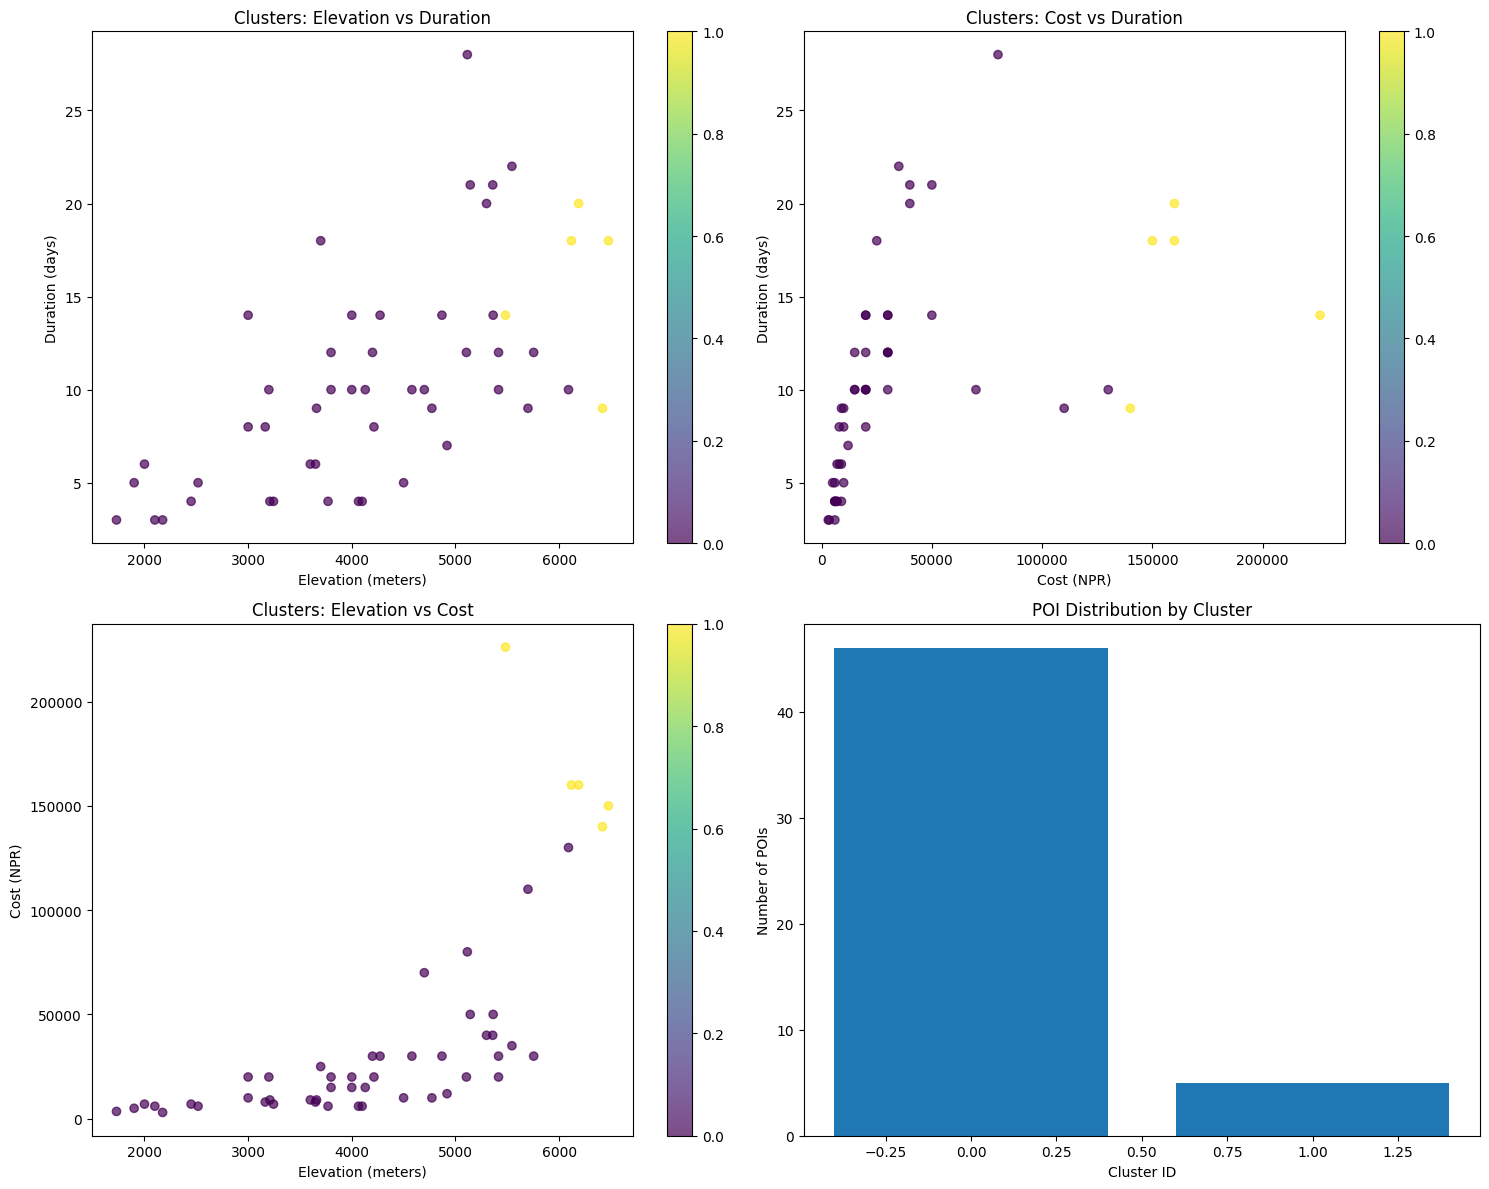

In [11]:
poi_model.visualize_clusters()

In [12]:
poi_model.get_recommendations({
    'difficulty': 'moderate',
    'max_elevation': 4000,
    'max_duration': 7,
    'max_cost': 15000
}, n_recommendations=5)

,poi_name,difficulty,elevation,duration,cost,similarity_score
45,Sailung Trek,Moderate,3600 meters,4-6 days,5000 NPR to 9000 NPR,0.723215
27,Helambu Trek,Beginner to Moderate,3650 meters,4-6 days,5000 NPR to 8000 NPR,0.439405
2,Ama Yangri Trek,Beginner friendly,3771 meters,3-4 days,4000 NPR to 6000 NPR,0.424726
0,Khumai Danda Trek,Beginner-friendly,3245 meters,3-4 days,5000 NPR to 7000 NPR,0.404985
25,Ghorepani Poon Hill Trek,Beginner-friendly,3210 meters,3-4 days,6000 NPR to 9000 NPR,0.403686
